[View in Colaboratory](https://colab.research.google.com/github/vishav/neuralstyletransfer/blob/master/neural_style_transfer.ipynb)

In [71]:

import  matplotlib.pyplot as plt
%matplotlib inline

import os 
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

from keras import  backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

This project was run on Google Colab, so the images were uplaoded using the below code.

In [72]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

In [106]:
upload_files()

Saving wave.jpg to wave (1).jpg
Saving vishav.jpg to vishav (1).jpg


['wave.jpg', 'vishav.jpg']

!ls will show all the files uploaded in the current session.

In [74]:
!ls

colorfulart.jpeg  datalab    venetian.jpeg  wave.jpg
content.jpg	  style.jpg  vishav.jpg


The uploaded style and content images will be resized to a specific height and width.

In [75]:
height=512
width=512

mean_arr contains the mean RGB value as mentioned in the paper- [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556). These values will be subtracted frome each pixel. These values were previously computed on the [ImageNet training set](http://image-net.org/)

In [76]:
mean_arr = np.array([103.939, 116.779, 123.68], dtype=np.float32)

Open both content and style images and resize them to the specified width and height

In [107]:
content_image=Image.open("vishav.jpg").resize((width, height))
style_image= Image.open("wave.jpg").resize((width, height))
content_image.size, style_image.size

((512, 512), (512, 512))

This utility function will subtract the mean_arr values from each pixel and flip the ordering from RGB to BGR, which is the ordering used in the paper.

In [108]:
def pre_process_image(x):
    pre_processing = lambda x: (x-mean_arr)[:, :, :, ::-1]
    return pre_processing(x)

This utility function is used to reconstruct the image.

In [109]:
def de_preprocess_image(x, shape):
    de_preprocessing = lambda x, shape: np.clip(x.reshape(shape)[:, :, :, ::-1]+mean_arr, 0,255)
    return de_preprocessing(x, shape)

First, we add a 4th dimension to content and style array.
Then, we process these arrays using the pre_process_image()

In [110]:
content_array = pre_process_image(np.expand_dims(np.array(content_image, dtype='float32'), axis=0))
style_array = pre_process_image(np.expand_dims(np.array(style_image, dtype='float32'), axis=0))

In [111]:
content_array.shape, style_array.shape

((1, 512, 512, 3), (1, 512, 512, 3))

We will define 3 new variables in keras backend (tensorflow graph). The first two will hold the content and the style images and the thrid is a placeholder variable which will store the content of the content image and the style of the style image.

In [112]:
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

Now, concatenate these three variables into a single tensor which will be used by the keras VGG16 model as an input tensor.

In [113]:
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

We will use the keras pre-trained VGG16 model. Also, as we are not doing any classification, so we dont need any fully-connected layers, softmax-classfier of the VGG16 model. By setting the **include_top=False**, the final model will not include these 5 layers (1 maxpool, 3 fully-connected layers and 1 softmax-classifier)

In [114]:
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)

Now, let's store our VGG16 model layers name and output in a dictionary so that we can use them later.

In [115]:
layers=dict([(layer.name, layer.output) for layer in model.layers])

The main idea behind the neural style transfer introduced in this paper is basically optimizing the loss i.e minimize this loss. This loss function can be split into: content loss, style loss and the total variation loss. The importance of each loss is determined by scalar weights. These weigths are arbitary, but I choose the following values were chosen after playing around with deifferent weigths and selecting the one which produced the final images, which was aesthetically pleasing to me.

In [116]:
content_weight = 0.05
style_weight = 5.0
total_variation_weight = 1.0

 Let's first initialize the total loss to 0.

In [117]:
loss=backend.variable(0.)

For the content loss, I chose to draw content feature from **block_conv2** as mentioned in the paper - [ Johnson, Alahi and Fei-Fei](https://arxiv.org/abs/1603.08155) instead of the **block4_conv2**, which was the choice in the [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), as it loses too much structural details.

The content loss is caculated as the Euclidean distance between feature representations of the content and the combination images.

In [118]:
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

Now, we first capture the output of the **block2_conv2** layer of our pre-trained VGG16 model. 
Next, we get the features of our content and the combination image. 
Pass these features to the above content_loss() and multiply the returned loss value with the content_weight. 

In [119]:
content_layer=layers['block2_conv2']
content_image_features=content_layer[0,:,:,:]
combination_features=content_layer[2,:,:,:]
loss+=content_weight*content_loss(content_image_features,combination_features)
content_layer.shape, content_image.shape, combination_features.shape, loss.shape

(TensorShape([Dimension(3), Dimension(256), Dimension(256), Dimension(128)]),
 TensorShape([Dimension(1), Dimension(512), Dimension(512), Dimension(3)]),
 TensorShape([Dimension(256), Dimension(256), Dimension(128)]),
 TensorShape([]))

To capture style_loss, we will use gram matrix, as it uses covariance to find the correlation between different features i.e which features tend to active together. Thus, it will let us capture the style information independent of content. 
This is different from the content loss, where we are trying to minimize the different between the content and the generated image.



In [120]:
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

In [121]:
def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

I have chosen the style features from the layers mentioned in the [ Johnson, Alahi and Fei-Fei](https://arxiv.org/abs/1603.08155) instead of the [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), as I found the end result to be more aesthetically pleasing. 

In [122]:
style_layer = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

Now, capture the output of each of the above style layers and get the features of the style and the combination image. Now, pass these features to the above style_loss() and multiply it with the style_weight. The total sum of the loss captured through each of the above style layer is the style loss.

In [123]:
for layer_name in style_layer:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(style_layer))*sl

To encourage spatial smoothness, we will add another term called [total_variation_loss](https://arxiv.org/abs/1412.0035) (a regularization term).

In [124]:
def  total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

In [125]:
loss += total_variation_weight * total_variation_loss(combination_image)

The goal behind this project was to create a combination image which will have the content image **content** and the style image **style**. So, now we will define the total loss gradients which are relative to the combination image, which will improve the combination image iteratively by minimizing the loss to make it look more like the content image with the style image style.

In [126]:
grads = backend.gradients(loss, combination_image)

In [127]:
outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

In [128]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

Evaluator class will retrieve loss and gradients from two different functions and will compute them in one pass. It's because scipy.optimize requires spearate functions for loss and gradients

In [129]:
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [130]:
evaluator=Evaluator()

**x** is the starting combination image with random pixels.

In [131]:
x=np.random.uniform(0,255,(1,height,width,3))-128.0

We will iterate for 10 iterations.

In [132]:
iterations = 10

We will use **L-BFGS-B** algorithm (it is an optimization algorithm which belongs to the quasi-Newton methods, which is converges quickly than the standard gradient descent).


In [0]:
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

In [104]:
# y = x.reshape((height, width, 3))
# y = y[:, :, ::-1]
# y[:, :, 0] += 103.939
# y[:, :, 1] += 116.779
# y[:, :, 2] += 123.68
# y = np.clip(y, 0, 255).astype('uint8')
y=de_preprocess_image(x,  style_array.shape)[0].astype('uint8')
y.shape

(512, 512, 3)

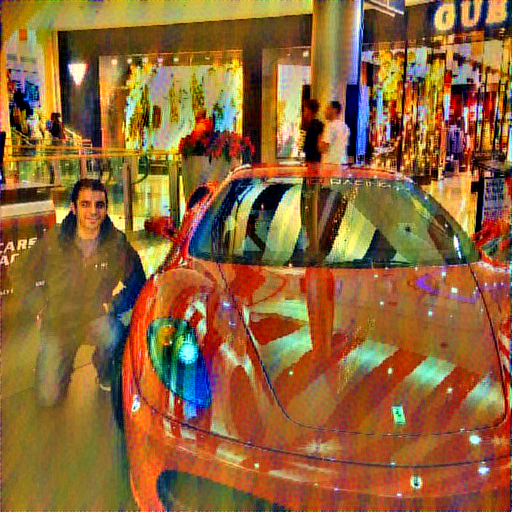

In [105]:
Image.fromarray(y)